# Setup

In [0]:
%tensorflow_version 1.x
from sklearn.model_selection import train_test_split
import os
%matplotlib inline
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from keras.preprocessing import image
#from keras.applications.vgg16 import preprocess_input
#from sklearn.model_selection import train_test_split

from keras.applications.xception import preprocess_input
from keras.applications.xception import Xception

from keras.layers import BatchNormalization,Dropout,InputLayer,Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.preprocessing import image
from keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


Defining the path for image directory 

In [0]:
path = input('Enter path of directory') 
os.chdir(path)
img_dir = path + "/images/"

In [0]:
#path of files

train_csv_file = path + "/train.csv"


In [0]:
data = pd.read_csv(train_csv_file)

In [0]:
data.shape

(13911, 2)

# Loading, Pre-processing and splitting data  

## Loading Data

In [0]:
files = data.image_names

In [0]:
def load_img(filename):
    img = image.load_img(filename, target_size=(150, 150,3))
    img = image.img_to_array(img)
    return img

In [0]:
images = []

In [0]:
for img_name in files:
  filename = img_dir + img_name
  img = load_img(filename)
  images.append(img)


file = open('images_list.pickle', 'wb') 
pickle.dump(images, file)                      
file.close()


Here, we have stored the images in pickle format, this makes it easier to load images, in case we need to run the code multiple times as readin images from directory every time is time consuming

In [0]:
file =  open("images_list.pickle","rb")
images = pickle.load(file)
file.close()
print(len(images))

13911


## Pre-processing data

In [0]:
images = np.asarray(images)

In [0]:
images.shape

(13911, 150, 150, 3)

In [0]:
X=preprocess_input(images)
y = data.iloc[:, 1].values

## Splitting data


In [0]:
X_train, X_valid, Y_train, Y_valid=train_test_split(X,y,test_size=0.3, random_state=42) #stratify=y

# Fine tune model for our problem

## Loading the pre-trained model

In [0]:
base_model = Xception(weights='imagenet', input_shape=(150, 150, 3), include_top=False)













83689472/83683744 [==============================] - 8s 0us/step


In [0]:
features_train = base_model.predict(X_train)
features_valid = base_model.predict(X_valid)

In [0]:
features_train.max()

15.96638

In [0]:
max_val = features_train.max()

In [0]:
features_train /= max_val
features_valid /= max_val

In [0]:
input_size = features_train.shape[1] * features_train.shape[2] * features_train.shape[3] 

In [0]:
features_train = features_train.reshape(features_train.shape[0], input_size)
features_valid = features_valid.reshape(features_valid.shape[0], input_size)



## Defining final layers of models

In [0]:
model=Sequential()
model.add(InputLayer((input_size, )))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=1, activation='linear')) # 1 output: age

adam = Adam(lr=1e-3)
model.compile(loss='mean_squared_error', optimizer=adam)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [0]:
estop = EarlyStopping(patience=15, mode='min', min_delta=0.001, monitor='val_loss')

In [0]:
history = model.fit(features_train, Y_train, epochs=200, batch_size=512, callbacks=[estop] ,validation_data=(features_valid,Y_valid))



Train on 9737 samples, validate on 4174 samples
Epoch 1/200
9737/9737 [==============================] - 32s 3ms/step - loss: 316.5190 - val_loss: 170.9014
Epoch 2/200
9737/9737 [==============================] - 30s 3ms/step - loss: 131.8801 - val_loss: 115.0143
Epoch 3/200
9737/9737 [==============================] - 31s 3ms/step - loss: 111.0679 - val_loss: 110.2073
Epoch 4/200
9737/9737 [==============================] - 30s 3ms/step - loss: 105.3137 - val_loss: 111.1985
Epoch 5/200
9737/9737 [==============================] - 30s 3ms/step - loss: 103.3404 - val_loss: 107.3498
Epoch 6/200
9737/9737 [==============================] - 32s 3ms/step - loss: 103.1462 - val_loss: 105.7369
Epoch 7/200
9737/9737 [==============================] - 30s 3ms/step - loss: 99.3759 - val_loss: 104.7334
Epoch 8/200
9737/9737 [==============================] - 30s 3ms/step - loss: 96.8820 - val_loss: 103.5751
Epoch 9/200
9737/9737 [==============================] - 30s 3ms/step - loss: 94.8292 - 

Plotting loss

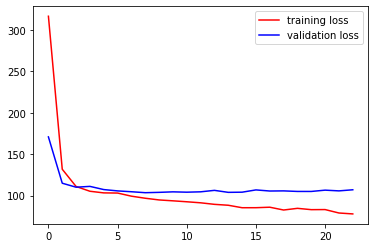

In [0]:
plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.legend({'training loss': 'r', 'validation loss':'b'})
plt.show()

Saving weights for our model

In [0]:
model.save_weights("age_weights.h5")

# Making predictions on new data

In [0]:
csv_file = "test.csv"
data = pd.read_csv(csv_file)

## Loading data

In [0]:
images = []
for img_name in data.image_names:
    filename = img_dir + img_name
    img = image.load_img(filename, target_size=(150, 150,3))
    img = image.img_to_array(img)
    images.append(img)


images=np.array(images)


Storing test images in a pickle file.

In [0]:
file = open('test_images.pickle', 'wb') 
pickle.dump(images, file)                      
file.close()

Loading pickled test images

In [0]:
file =  open("test_images.pickle","rb")
images = pickle.load(file)
file.close()
print(len(images))

5962


In [0]:
X=preprocess_input(images)

## Loading the saved weights and preparing model for prediction

In [0]:
base_model = Xception(weights='imagenet', input_shape=(150, 150, 3), include_top=False)

In [0]:
features = base_model.predict(X)

In [0]:
features /= features.max()

In [0]:
input_size = features.shape[1] * features.shape[2] * features.shape[3]

In [0]:
features = features.reshape(features.shape[0], input_size)

In [0]:
model=Sequential()
model.add(InputLayer((input_size, )))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=1, activation='linear'))

adam = Adam(lr=1e-3)
model.compile(loss='mean_squared_error', optimizer=adam)

In [0]:
model.load_weights("age_weights.h5")

## Make predictions

In [0]:
#print(type(features))

In [0]:
y = model.predict(features)

In [0]:
print("min: ",y.min())
print("max: ",y.max())

min:  17.09322
max:  52.70974


In [0]:
print(y.dtype)

float32


In [0]:
output = pd.DataFrame(y)

In [0]:
data['age_labels'] = output

In [0]:
data.head()

,image_names,age_labels
0,3950.jpg,37.991394
1,1272.jpg,33.104393
2,14384.jpg,30.618887
3,18501.jpg,36.154205
4,3165.jpg,26.751371


In [0]:
data = data.astype({"age_labels": int})

Checking the minimum and maximum of predicted ages

In [0]:
print(data['age_labels'].min())
print(data['age_labels'].max())

17
52


In [0]:
data.to_csv("final_output.csv",index = False)

Let us have a look at how our model has predicted the ages for the new images

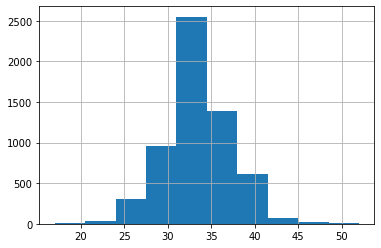

In [0]:
data['age_labels'].hist()